In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

In [83]:
import shap
import imblearn

In [103]:
shap.initjs()
%matplotlib inline

In [85]:
def print_metrics(y_test,predictions,model):
    print('\033[1m' + model + '\033[0m' + '\n\n')
    print('\033[1m' + 'Classification Report - ' + '\033[0m')
    print(classification_report(y_test, predictions))
    print('\033[1m' + 'ROC AUC Score - ' + '\033[0m')
    print(roc_auc_score(y_test, predictions))
    print('\033[1m' + 'Accuracy Score - ' + '\033[0m')
    print(accuracy_score(y_test, predictions))

In [86]:
def dtree(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18)
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    predictions_dt = dt.predict(X_test)
    print_metrics(y_test, predictions_dt, 'Decision Tree')

In [87]:
def rforrest(X,Y,n):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18)
    rfc = RandomForestClassifier(n_estimators=n,n_jobs=-1)
    rfc.fit(X_train,y_train)
    predictions_rfc = rfc.predict(X_test)
    print_metrics(y_test, predictions_rfc, 'Random Forrest')

In [88]:
def lgbm_runner(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18)
    train_lgb = lgb.Dataset(data=X_train, label=y_train)
    test_lgb = lgb.Dataset(data=X_test, label=y_test)
    params = {
        'task': 'train', 
        'boosting_type': 'gbdt', 
        'objective': 'binary', 
        'metric': 'auc', 
        'learning_rate': 0.02, 
        'num_leaves': 50, 
        'verbose': 0, 
        'colsample_bytree': 0.6, 
        'subsample': 0.9, 
        'max_depth': 10, 
        'reg_alpha': 0.5, 
        'reg_lambda': 0.0, 
        'min_split_gain': 0.01, 
        'min_child_weight': 40
    }
    model = lgb.train(params, train_lgb,500)
    predictions_lgb = model.predict(X_test)
    print('\033[1m' + 'Light GBM' + '\033[0m' + '\n\n')
    print('\033[1m' + 'ROC AUC Score' + '\033[0m')
    print(roc_auc_score(y_test, predictions_lgb))
    lgb.plot_importance(model, figsize=(10,25), max_num_features=100)
    return model
    

In [89]:
X = pd.read_csv('../input/final_data.csv')
Y = pd.read_csv('../input/final_target.csv', header=None)

In [90]:
Y.columns = ['x','TARGET']
Y = Y.drop('x', axis=1)

In [91]:
dtree(X,Y)

Decision Tree


Classification Report - 
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     56582
         1.0       0.16      0.18      0.17      4921

   micro avg       0.86      0.86      0.86     61503
   macro avg       0.54      0.55      0.54     61503
weighted avg       0.87      0.86      0.86     61503

ROC AUC Score - 
0.5479020163990649
Accuracy Score - 
0.8563809895452255


In [92]:
rforrest(X,Y,200)

/home/umang/.conda/envs/BTP/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forrest


Classification Report - 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56582
         1.0       1.00      0.00      0.00      4921

   micro avg       0.92      0.92      0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.93      0.92      0.88     61503

ROC AUC Score - 
0.5002032107295266
Accuracy Score - 
0.9200201616181325


Light GBM


ROC AUC Score
0.7813105437838243


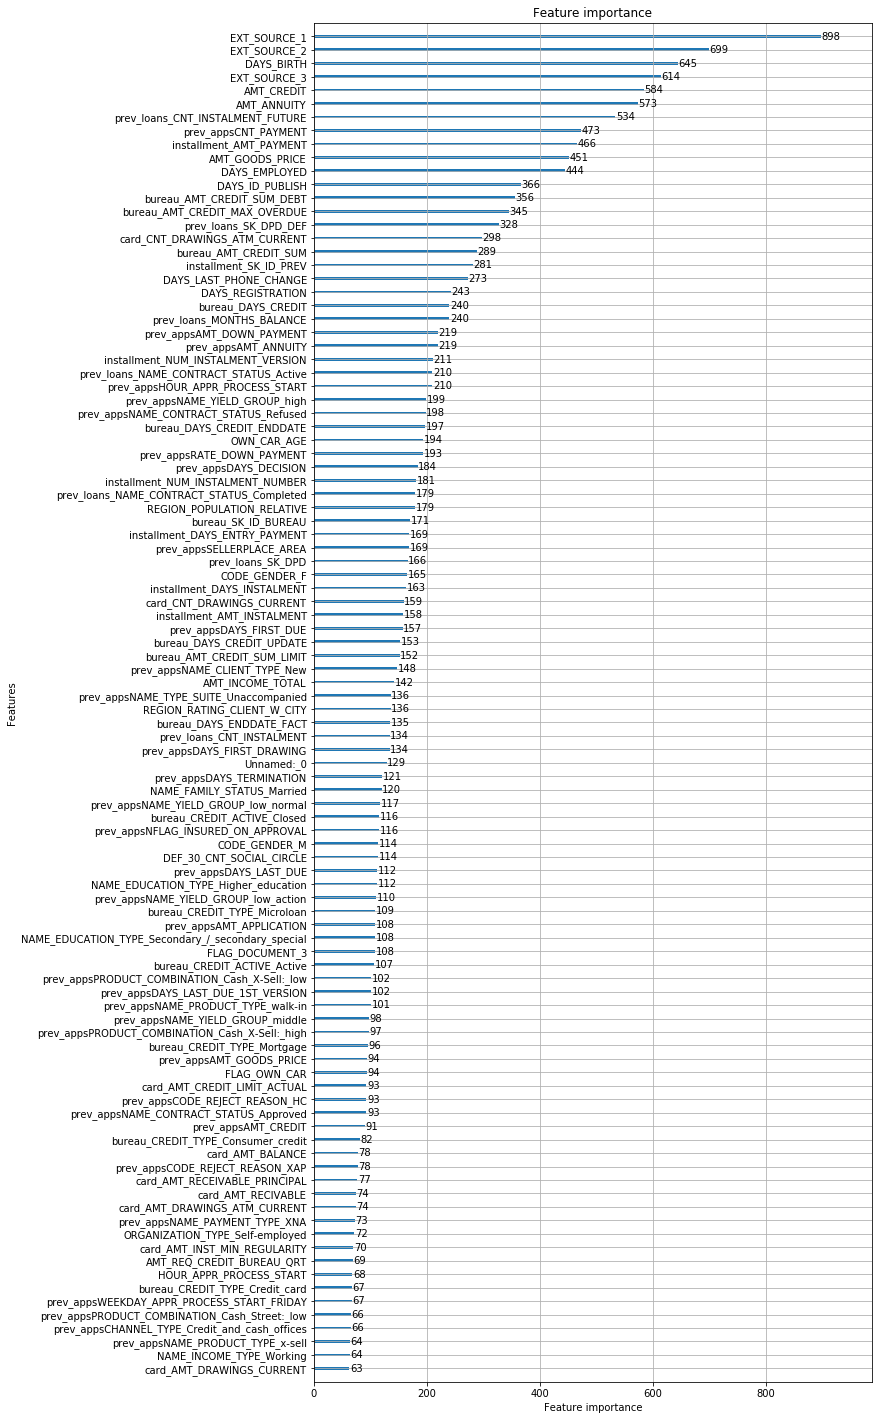

In [93]:
model = lgbm_runner(X,Y)

In [94]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_feature_importance_global = np.mean(shap_values)

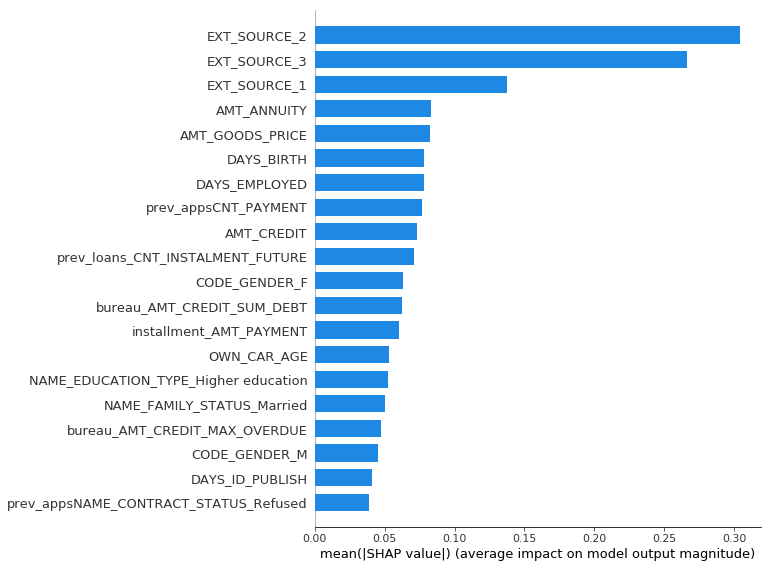

<class 'NoneType'>


In [109]:
# Global Feature Importance: the aggregated effect of features on the shap values for all the training observations
# Higher shap value => higher chance of default (target=1)
shap.summary_plot(shap_values, X, plot_type="bar")

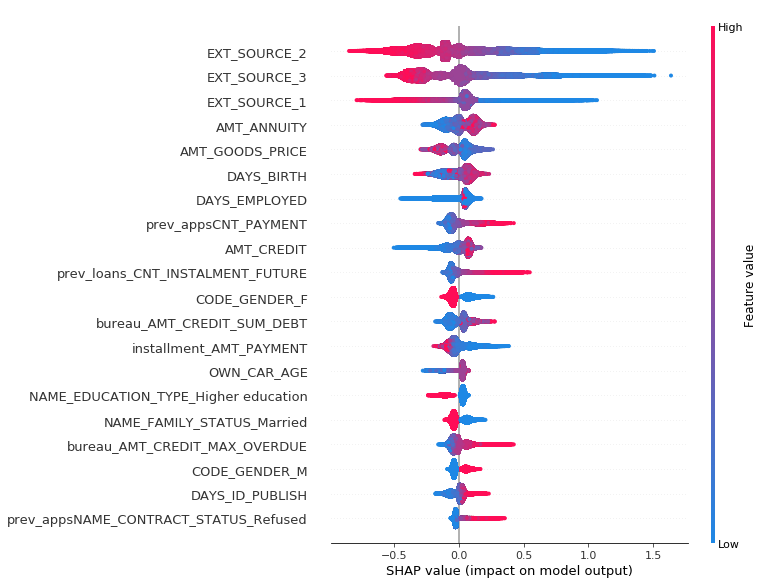

In [97]:
# How the value of each feature influences the shap values, the colour represents values of features
# the x axis represents the shap values
# the thickness of the line for each feature represents the number of observations with same shap value
# higher the horizontal dispersion of data points for a given feature implies the feature is more important 
# since it has a substantial effect on the shap values
shap.summary_plot(shap_values,X )

In [98]:
# interpretation example observations with low value of ext_source_2 are likely to have higher shap value
# and therefore are at a higher risk of default
# AMT_CREDIT: the shap values are low for observations with low AMT_CREDIT which suggests that observations
# with low AMT_CREDIT are unlikely to default and since shap values do not increase significantly for high AMT_CREDIT
# this feature is not informative if the values are high

# bureau_amt_credit_max_overdue: as the amount of overdue credit increases the shap values increase: this inference
# is due to the fact that the colour as the colour gradually changes to red the shap values increase

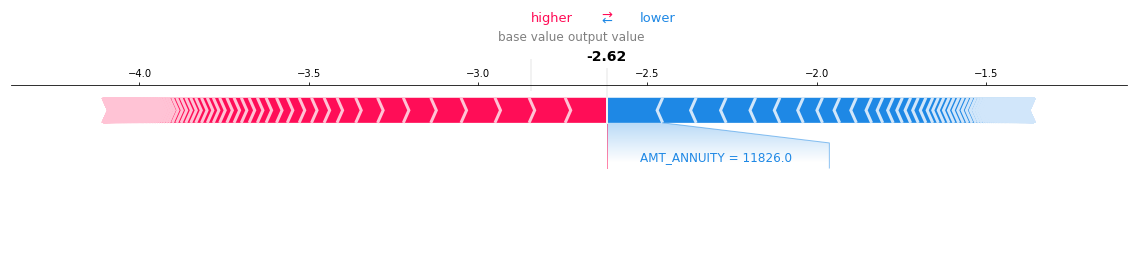

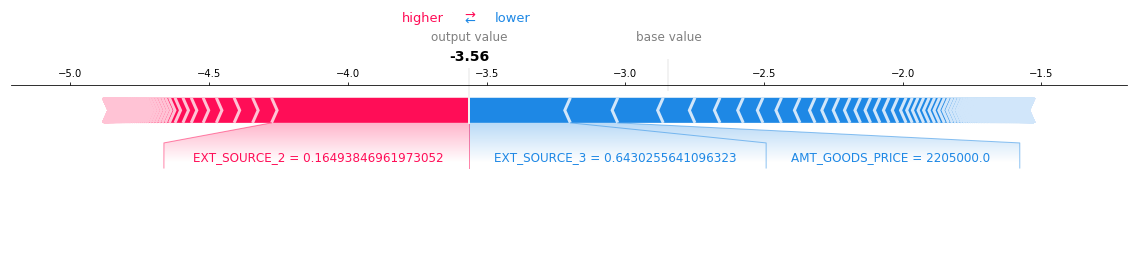

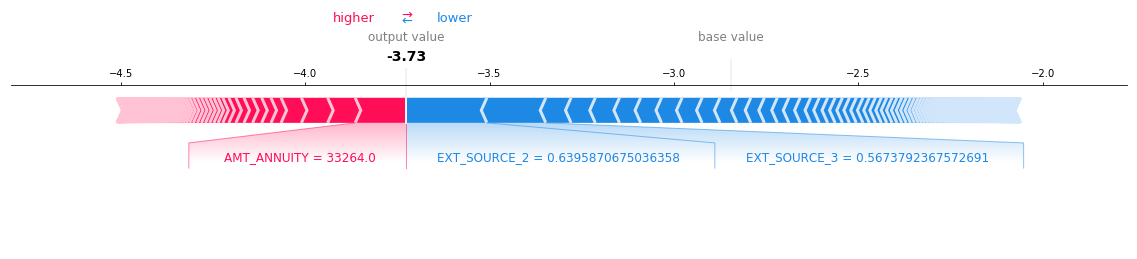

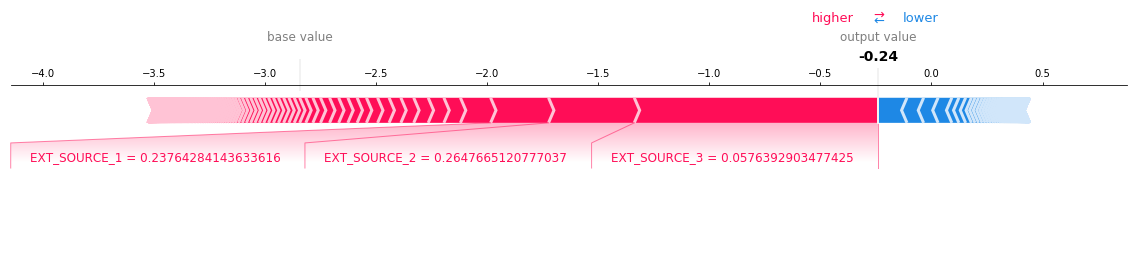

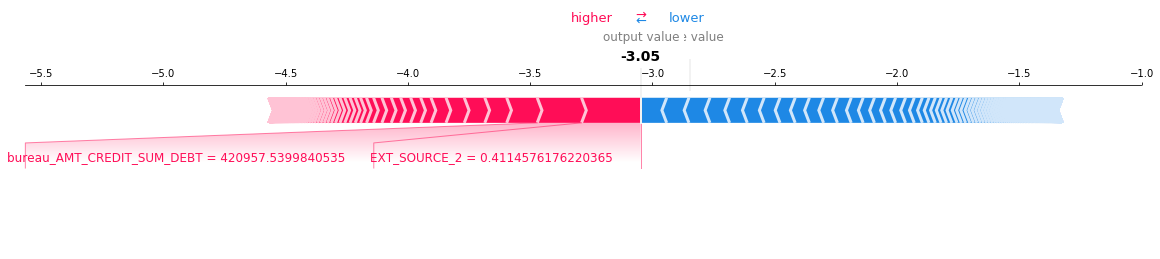

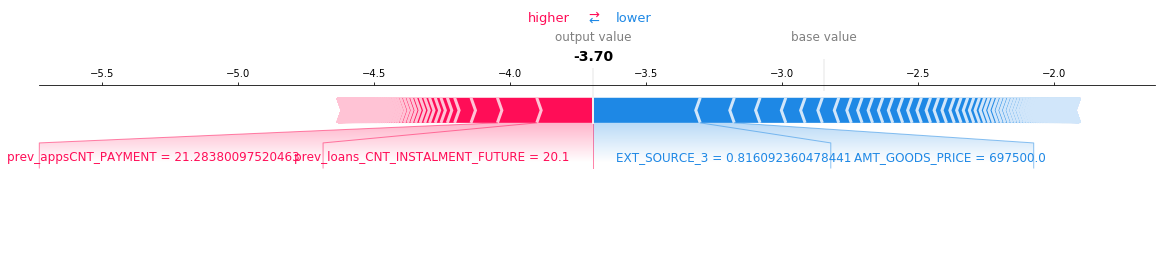

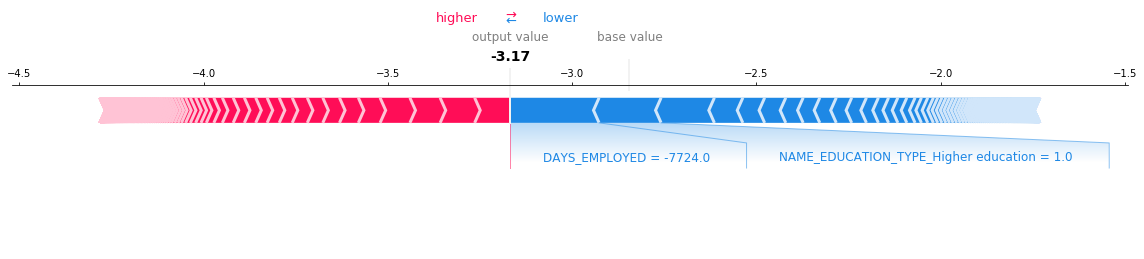

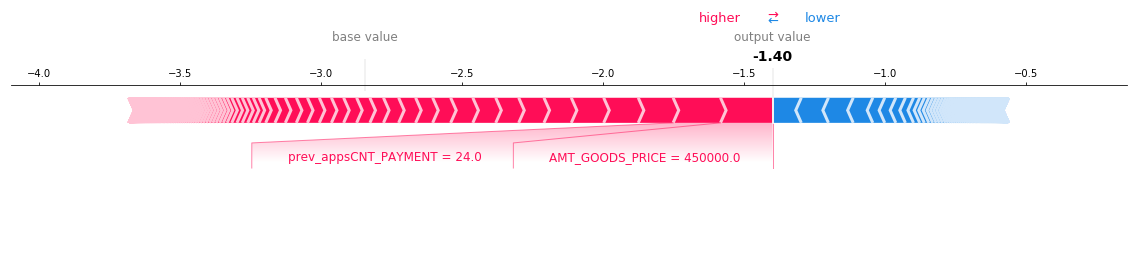

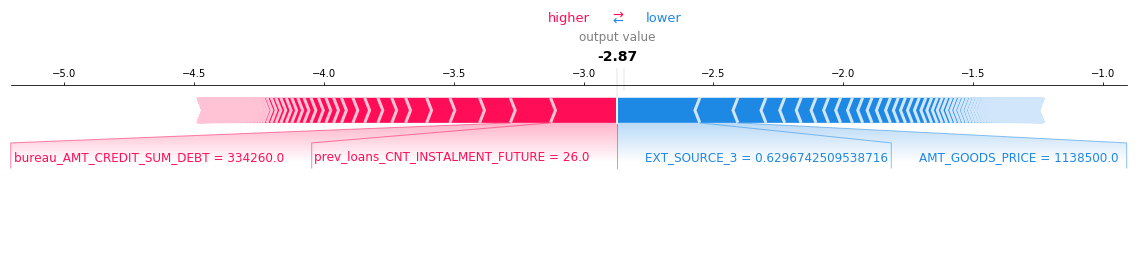

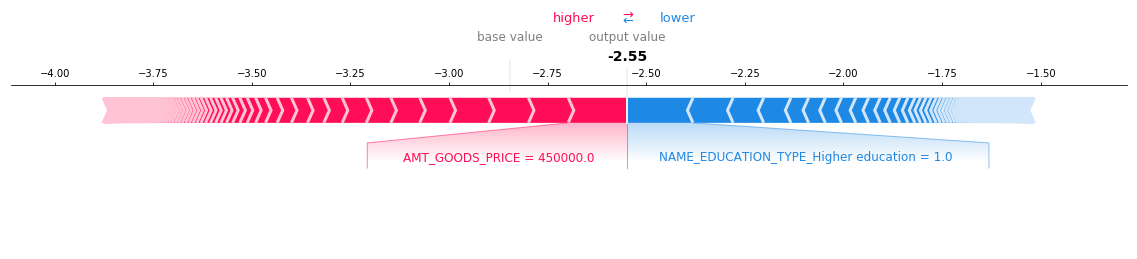

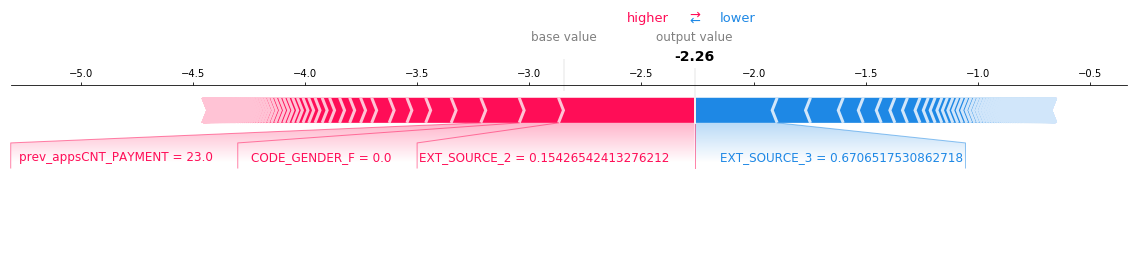

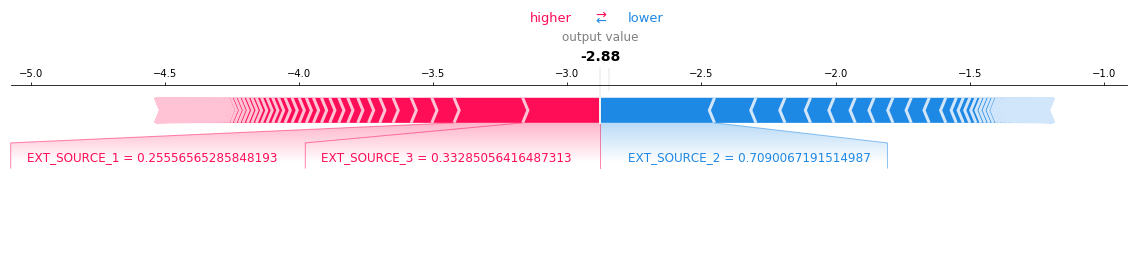

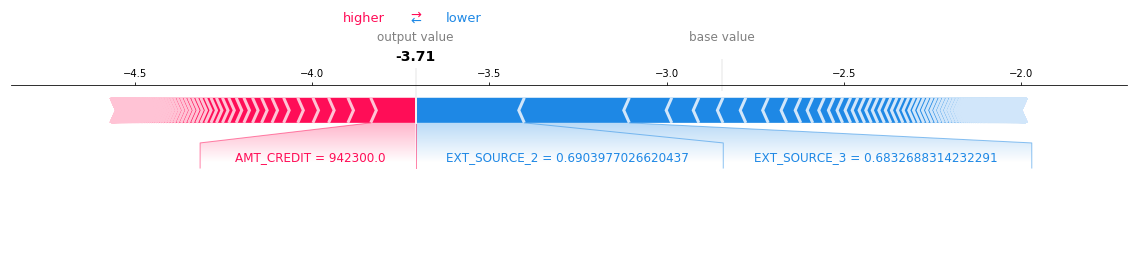

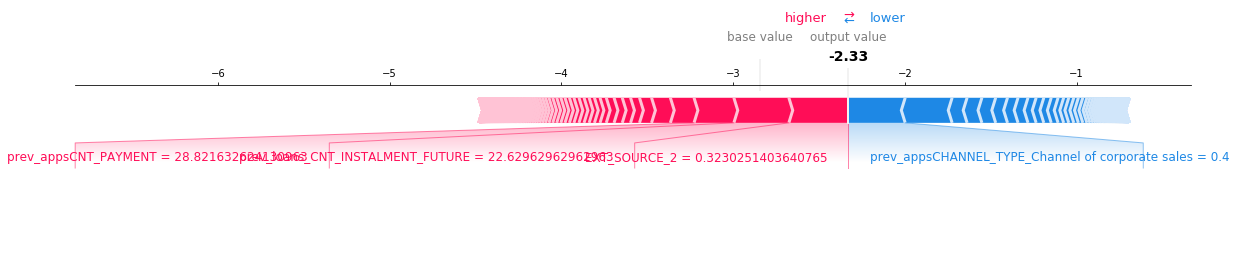

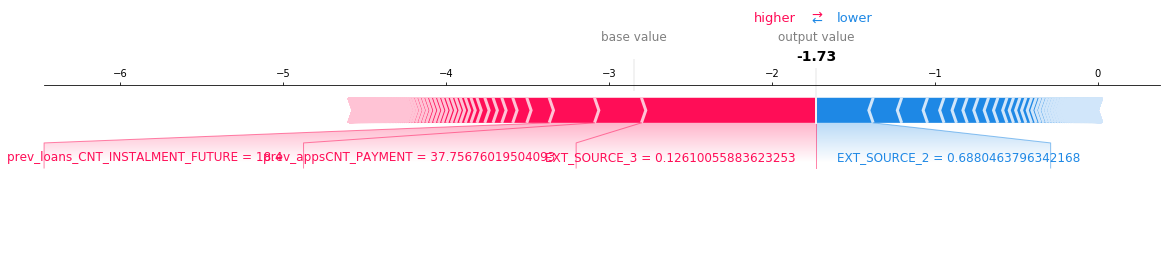

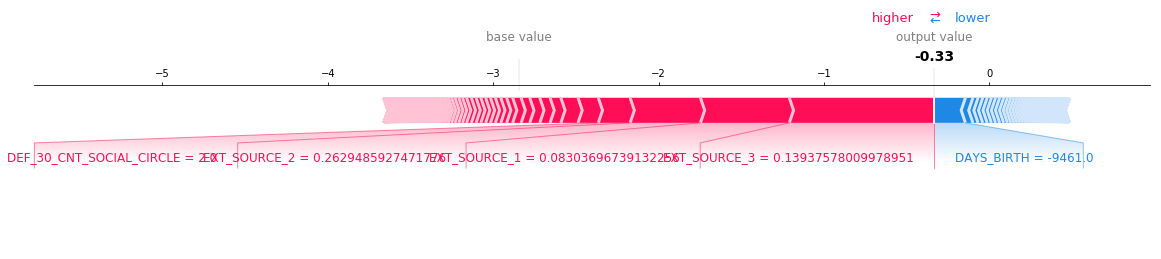

In [105]:
# select random subset of 10 observations and identify effects of different feature values on the shap_value
# for individual observations
shap.initjs()

idxs = np.random.randint(0, X.shape[0], size = 15)
for i in idxs:
    shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i, :], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0, :], matplotlib=True)

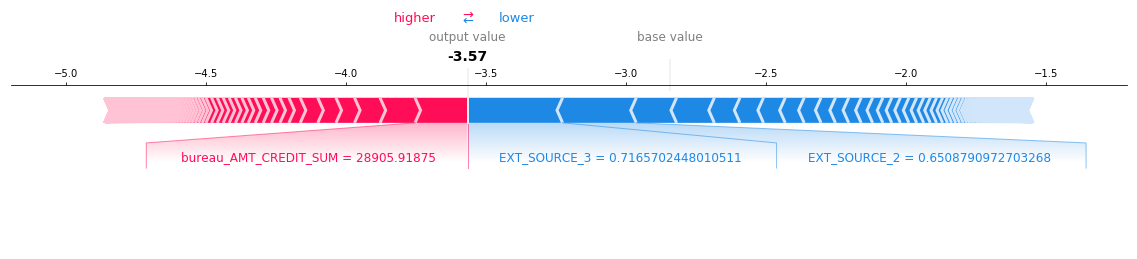

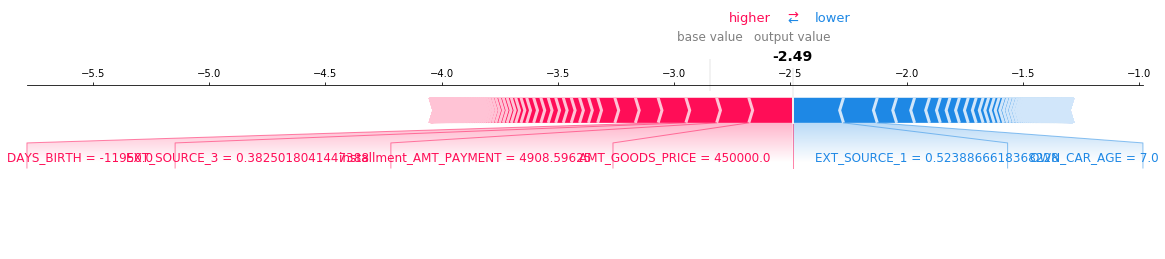

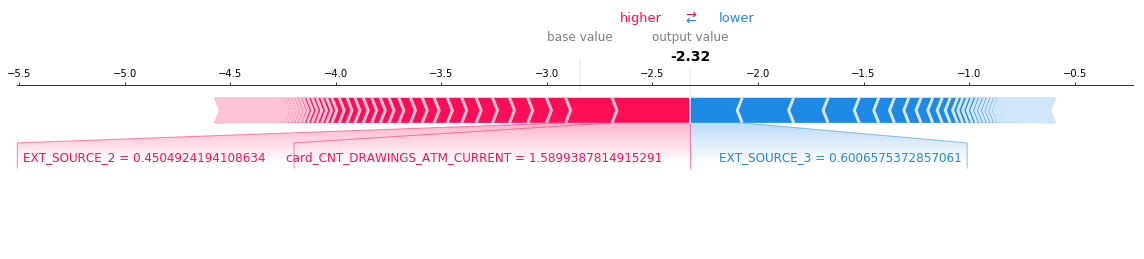

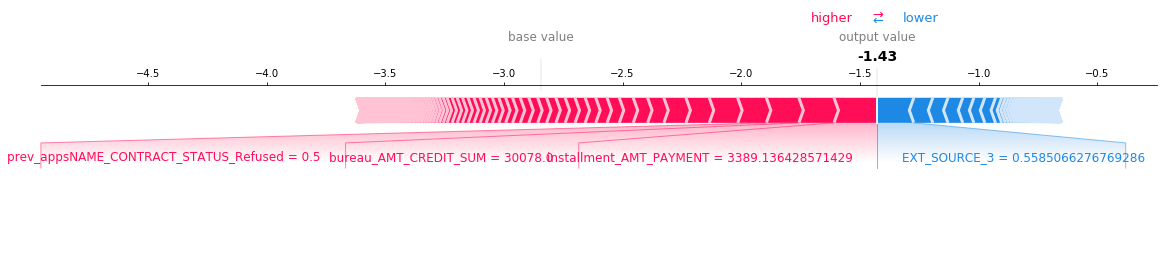

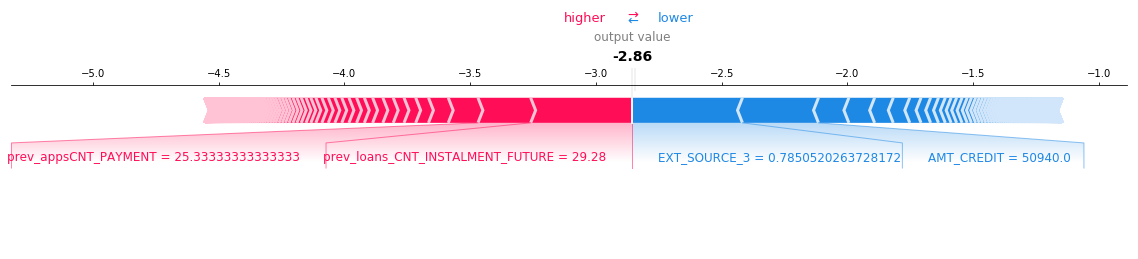

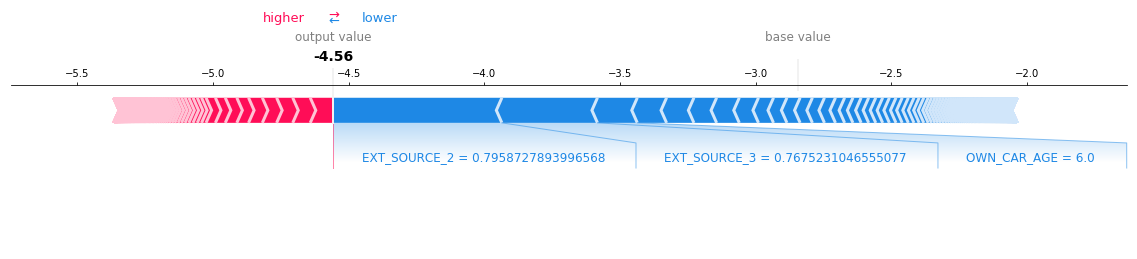

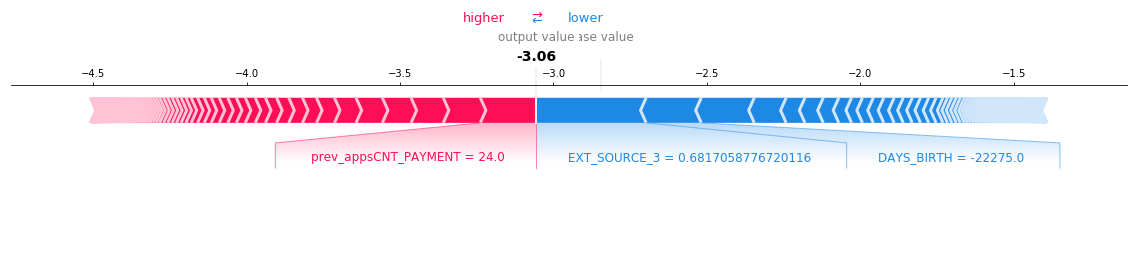

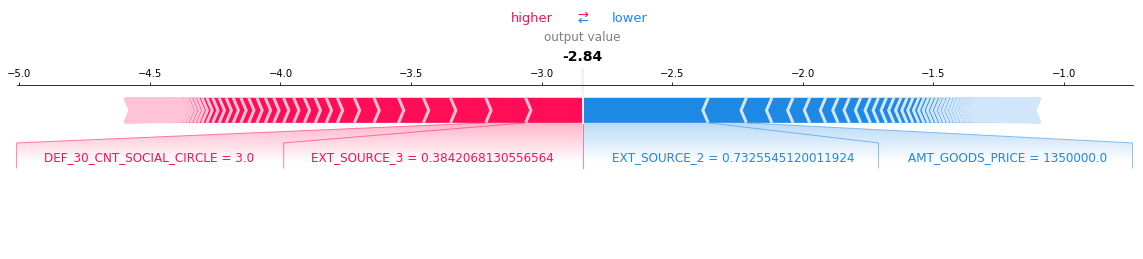

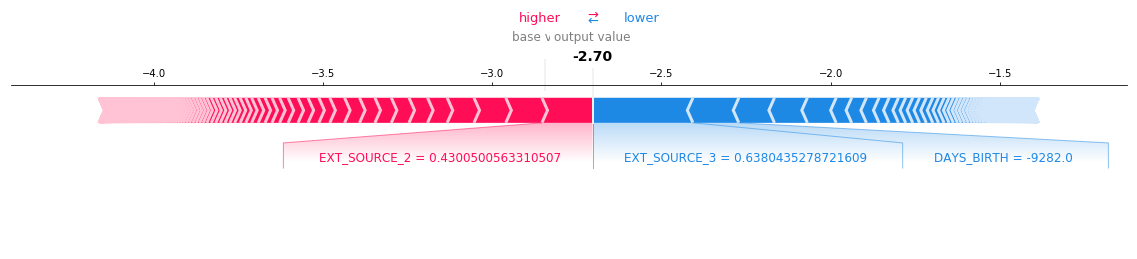

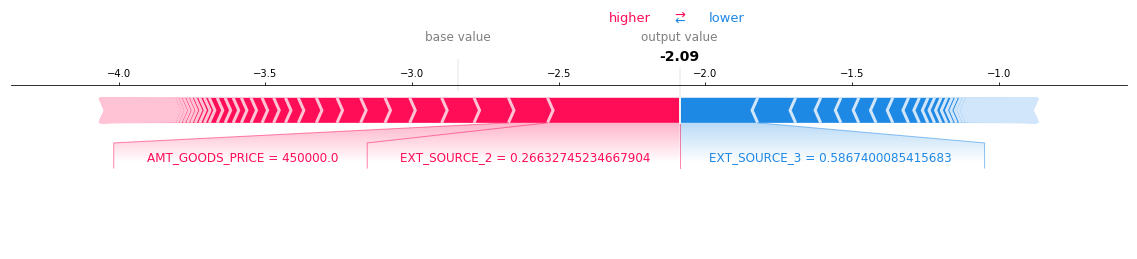

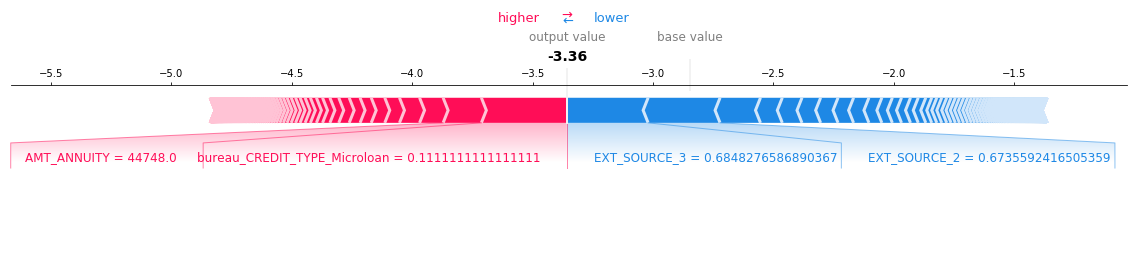

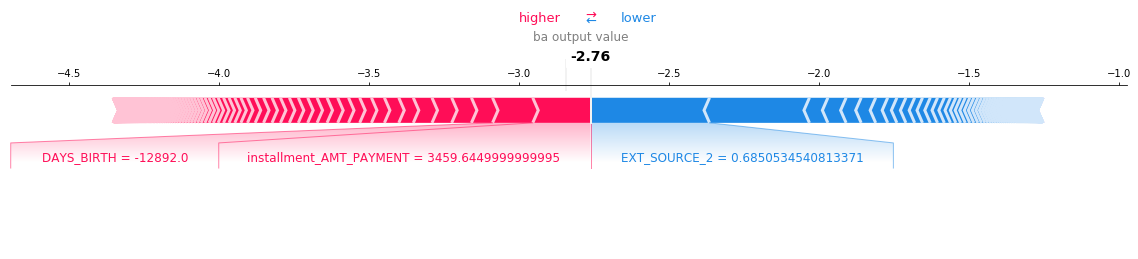

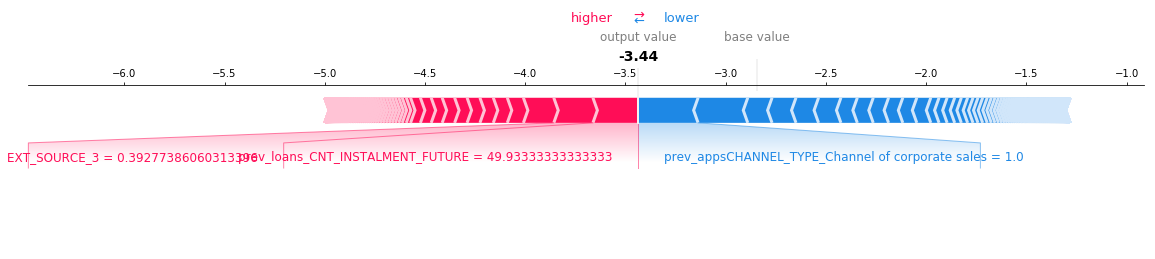

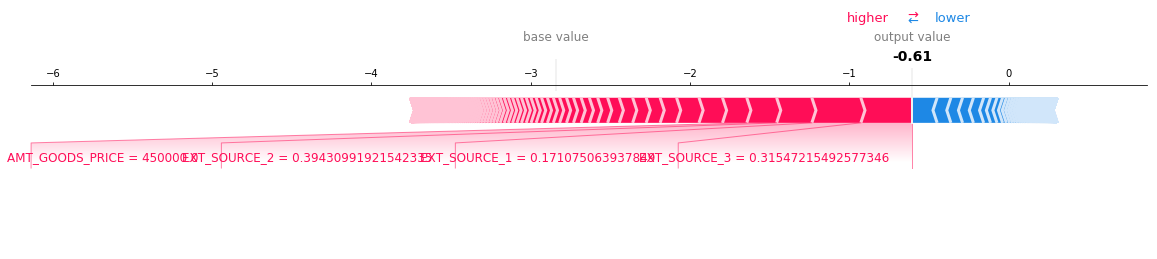

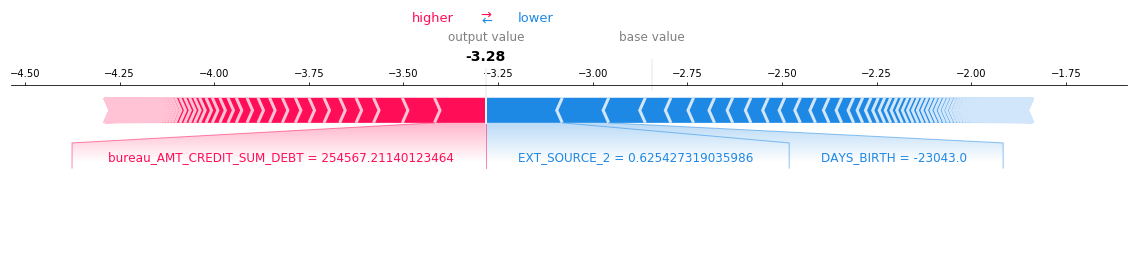

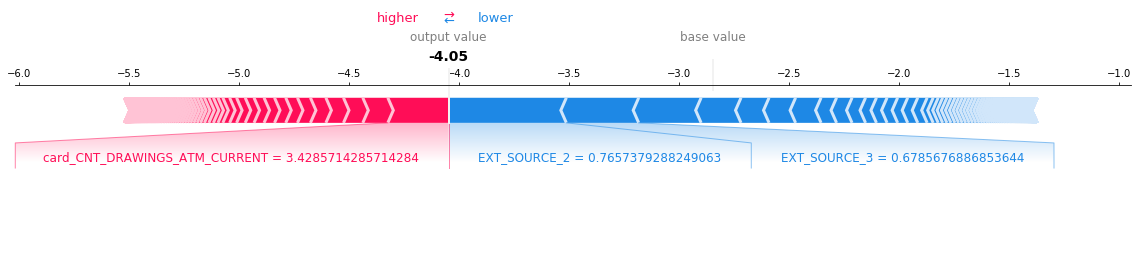

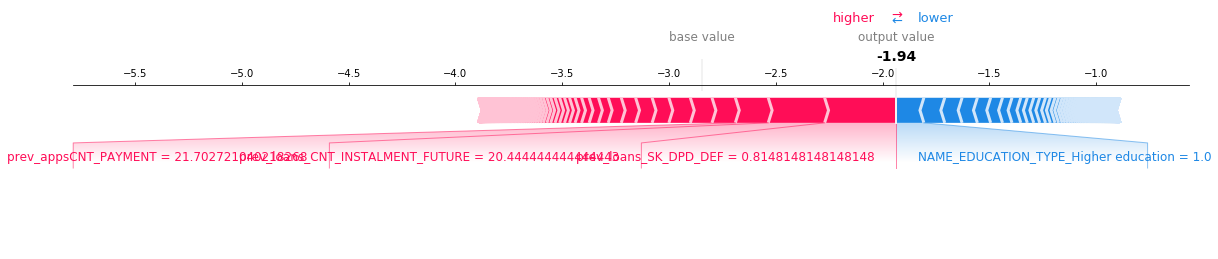

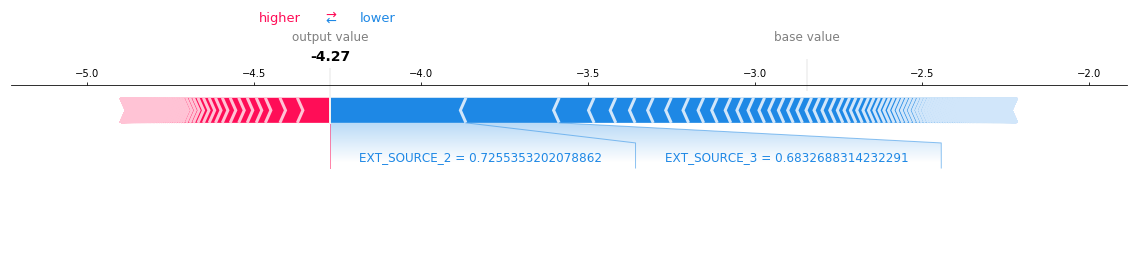

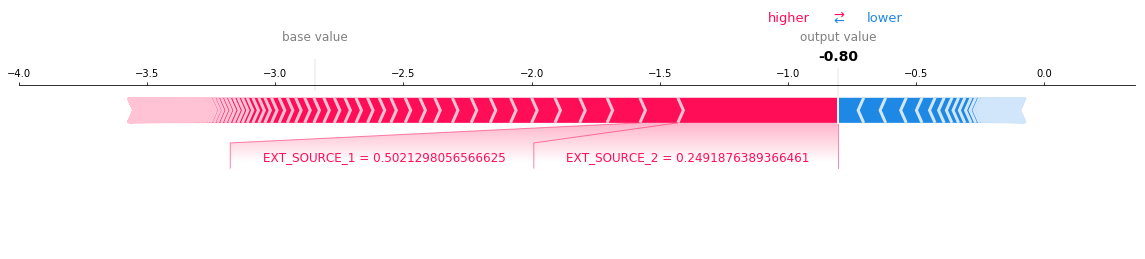

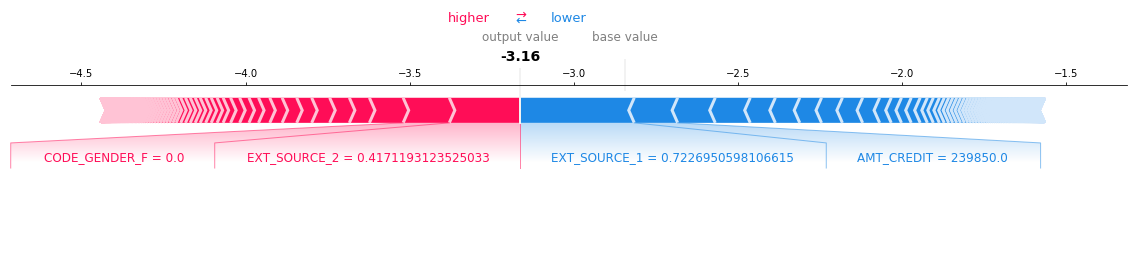

In [106]:
idxs = np.random.randint(0, X.shape[0], size = 20)
for i in idxs:
    shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i, :], matplotlib=True)

Investigate the dependence of the model on each feature
The summary plot above gives a lot of information. But we can learn more by examining a single feature and how it impacts the model's predicition across all the samples. To do this we plot the SHAP value for a feature on the y-axis and the original value of the feature on the x-axis. Doing this for all samples for EXT_SOURCE_2 shows a fairly linear relationship that flattens near high values. Note that the impact of EXT_SOURCE_2 on the model output is different for different people that have the same value of EXT_SOURCE_2, as shown by the vertical spread of the dots at a single point on the x axis. This is because of interaction effects (and would disappear if the trees were all depth 1 in the LightGBM model). To highlight what interactions may be driving this vertical spread shap colors the dots by another feature that seems to explain some of the dispersion (see the docs for more details on getting the exact interaction effects). For EXT_SOURCE_2 we see gender seems to have some effect.

In [107]:
# Plot shap dependence plots for the top 20 features

# extract top 20 features from lgbm 
top_20_features = list(pd.DataFrame({'Feature': model.feature_name(), 'Value': model.feature_importance()}).sort_values(by='Value',ascending=0).head(20)['Feature'])

In [108]:
print(top_20_features)

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'EXT_SOURCE_3', 'AMT_CREDIT', 'AMT_ANNUITY', 'prev_loans_CNT_INSTALMENT_FUTURE', 'prev_appsCNT_PAYMENT', 'installment_AMT_PAYMENT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'bureau_AMT_CREDIT_SUM_DEBT', 'bureau_AMT_CREDIT_MAX_OVERDUE', 'prev_loans_SK_DPD_DEF', 'card_CNT_DRAWINGS_ATM_CURRENT', 'bureau_AMT_CREDIT_SUM', 'installment_SK_ID_PREV', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']


In [110]:
top_20_features.extend(['CODE_GENDER_M', 'NAME_EDUCATION_TYPE_Higher education', 'OWN_CAR_AGE', 'NAME_FAMILY_STATUS_Married'])

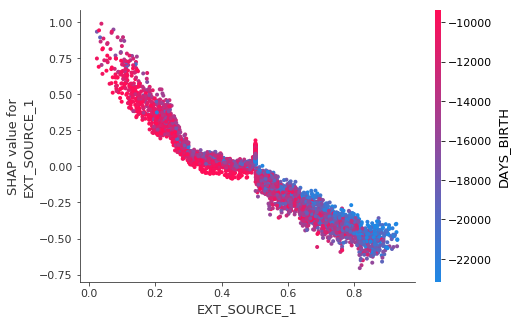

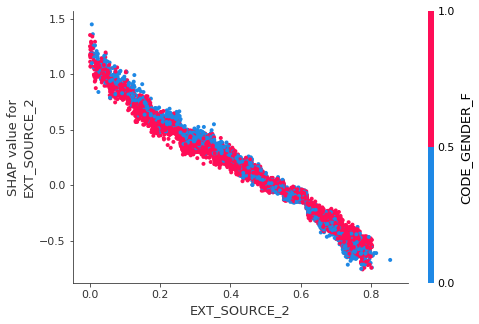

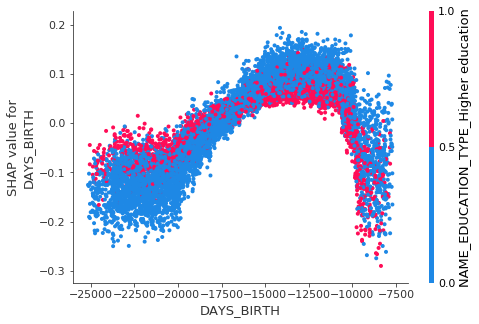

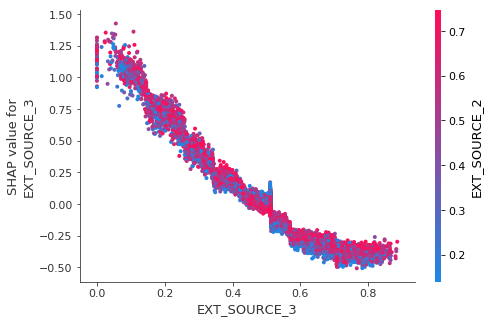

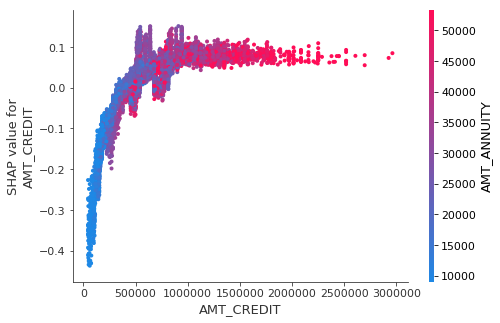

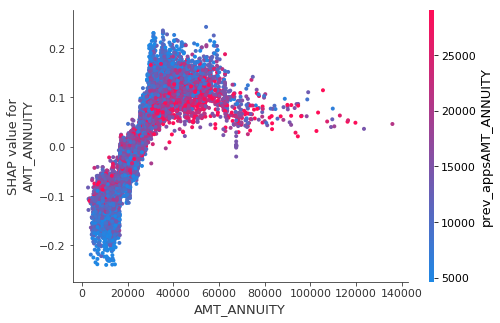

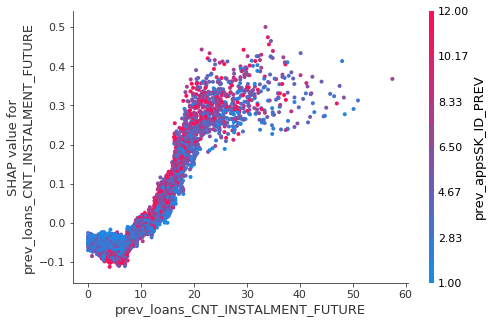

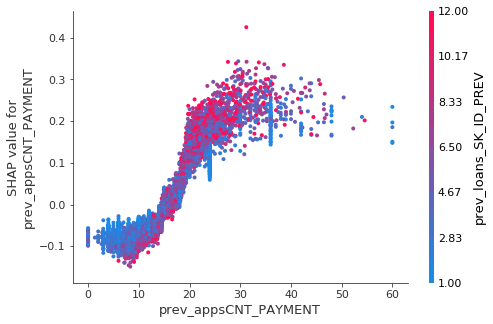

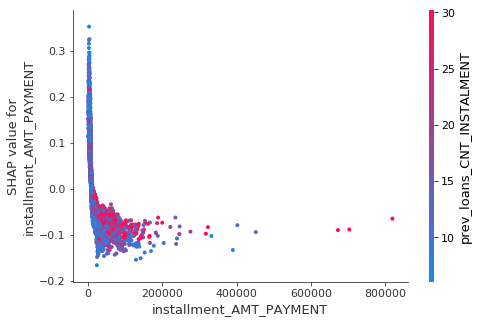

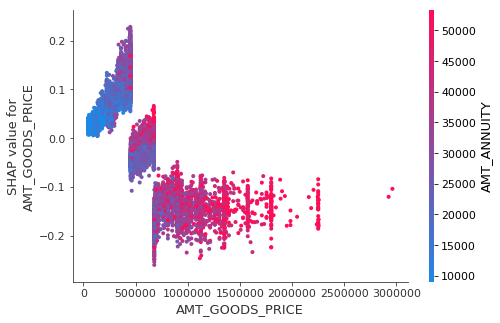

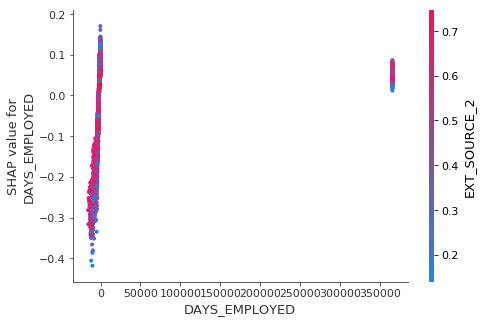

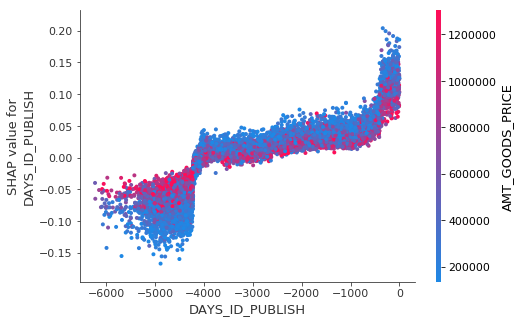

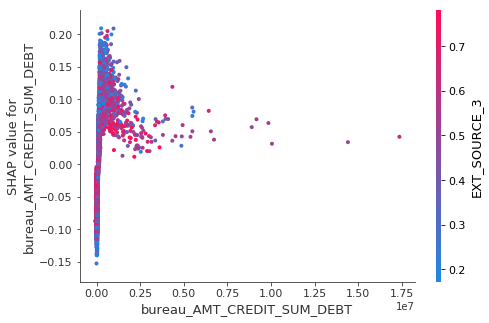

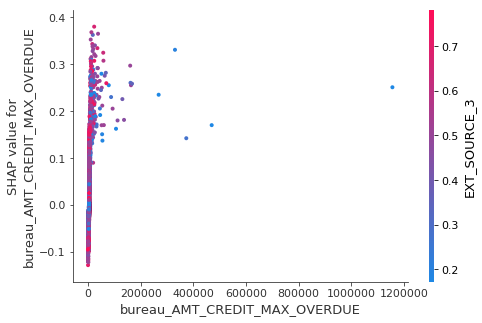

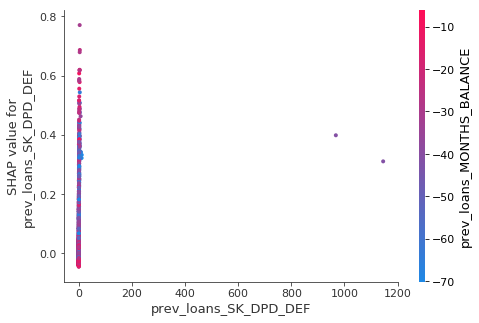

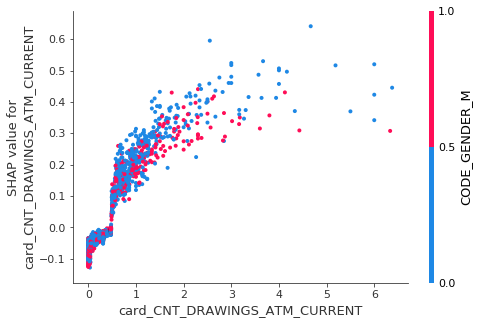

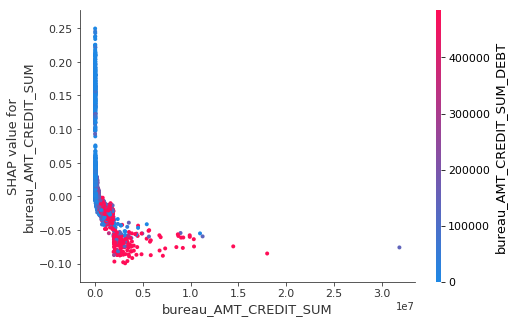

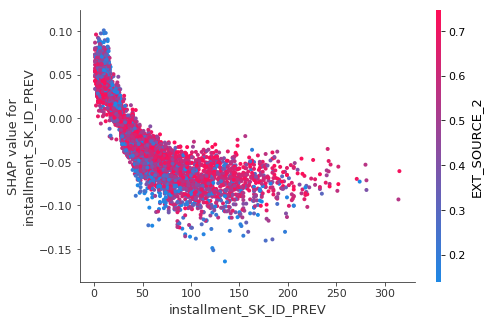

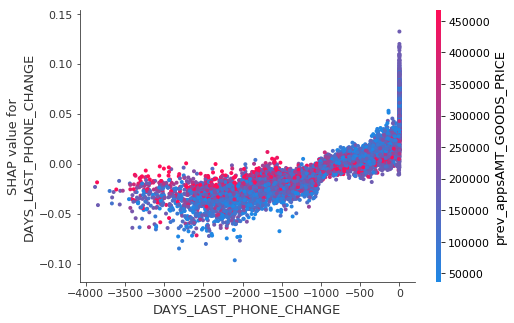

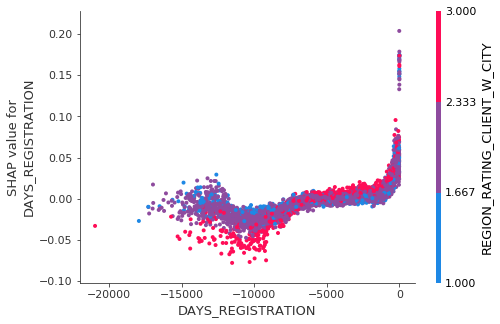

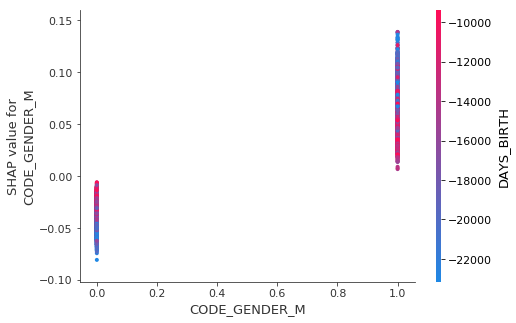

Could not find feature named: NAME_EDUCATION_TYPE_Higher Education


MemoryError: 

In [112]:
for i in top_20_features:
    shap.dependence_plot(i, shap_values[:10000, :], X.iloc[:10000, :])

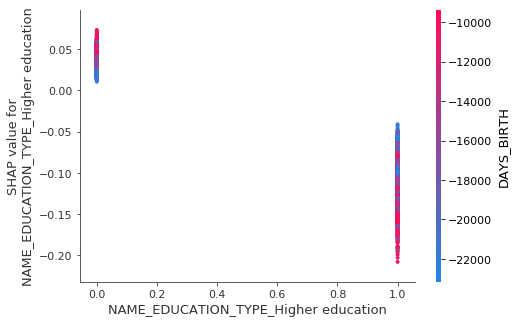

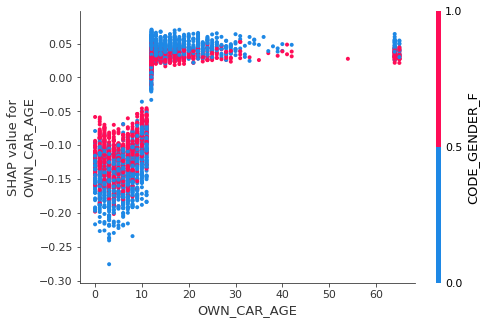

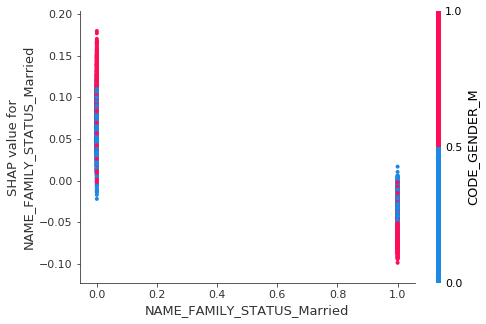

In [114]:
for i in ['NAME_EDUCATION_TYPE_Higher education', 'OWN_CAR_AGE', 'NAME_FAMILY_STATUS_Married']:
    shap.dependence_plot(i, shap_values[:10000, :], X.iloc[:10000, :])